In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Risk Measure
### What is a risk measure?
A risk measure works like a score for an exposure. If an exposure has a higher risk, the risk measure should be higher. However, this depends on the properties of risk measures. One of the very popular risk measures is the standard deviation but it does not have the transition invariance property, which is a property that if a certain amount is added to the exposure, the risk measure is deducted by that amount (read more at [Wikipedia](https://en.wikipedia.org/wiki/Coherent_risk_measure)).
### Quantile Function
The quantile function is a risk measure that gives the probability that a random valiable is less than a certain value. In other words, it is the inverse cumulative distribution function of a random variable.
Given that
$$ F_X (x) \coloneqq P(X<x)$$
The quantile function is
$$ Q(p) = F_X^{-1} (p)$$
### Value at Risk
Value at risk (V@R) determines the minimum value that a random variable can fall lower under a certain probability ($1-\alpha$). Note that there are various definitions for V@R and this is just a simplified version.
$$ \text{VaR}_\alpha (X) = -\text{inf}\{x \in \mathbb{R} : F_X (x) > \alpha \} = F_{-X}^{-1} (1-\alpha) $$
### Expected Shortfall
Expected shortfall is a risk measure which estimates the average loss of a random variable. The average loss is the losses at least at the V@R. This means the expected shortfall includes all possibble losses beyond the V@R. 
$$ \text{ES}_\alpha (X) = \text{E}[-X | X\le-\text{VaR}_\alpha (X)]  = \frac{1}{1-\alpha} \int_\alpha^1 \text{VaR}_s (X) ds = \frac{1}{1-\alpha} \left(-\text{E}[X \cdot 1_{\{X\le-\text{VaR}_\alpha (X)\}}] + \text{VaR}_\alpha (X)(\text{P}(X \le x_\alpha) - \alpha)\right)$$

Note that: $\alpha$ in this place is the left-tail risk and $\alpha = $ 1 - the confident level

In [2]:
# CDF
def cdf_non_para(data, x):
    data = np.array(data)
    sorted_data = np.sort(data)

    arange_data = np.arange(len(data))
    percentile_sorted_data = arange_data/(len(data)-1) # len(data) - 1 because we count the first sample as the 0th percentile
    
    if max(sorted_data) <= x:
        position = 1.0

    elif min(sorted_data) > x:
        position = 0.0

    else:
        for i in range(1, len(data) + 1):
            if (sorted_data[i] > x): # This condition checks the next position
                partial_part = (x-sorted_data[i-1])/(sorted_data[i] - sorted_data[i-1])*(percentile_sorted_data[i] - percentile_sorted_data[i-1]) # assume that the risk between two samples is linear
                integer_index = i - 1
                position = percentile_sorted_data[integer_index] + partial_part
                break
            
            elif (sorted_data[i] == x) & (sorted_data[i+1] != sorted_data[i]): # This condition checks this exact position
                integer_index = i
                position = percentile_sorted_data[integer_index]
                break

    cdf = position
    return cdf

In [3]:
# V@R
def var_non_para(data, alpha):
    data = np.array(data)
    sorted_data = np.sort(data)
    
    arange_data = np.arange(len(data))
    percentile_sorted_data = arange_data/(len(data)-1)

    if max(percentile_sorted_data) <= alpha: # max(percentile_sorted_data) is 1
        integer = len(data) - 1
        partial = 0
        sorted_data = np.append(sorted_data, sorted_data[-1])

    elif min(percentile_sorted_data) >= alpha:
        integer = 0 # This is because we do not know the minimum value, so we assume that the minimum value is the smallest sample
        partial = 0

    else:
        for i in range(1,len(data)):
            if (percentile_sorted_data[i] > alpha):
                partial = (alpha-percentile_sorted_data[i-1])/(percentile_sorted_data[i] - percentile_sorted_data[i-1]) # assume that the risk between two samples is uniform
                integer = i - 1
                break
            
            elif (percentile_sorted_data[i] == alpha):
                integer = i 
                partial = 0
                break

    var = sorted_data[integer] + (sorted_data[integer + 1] - sorted_data[integer]) * partial
    return var

# note that we can just simply use .quantile for the value at risk
# For example: pd.DataFrame([sample]).quantile([alpha], interpolation="linear")

In [4]:
# Expected Shortfall
def ES_non_para(data, alpha):
    data = np.array(data)
    sorted_data = np.sort(data)

    var = var_non_para(data, alpha)

    prob_left_risk = len(sorted_data[sorted_data <= var])/len(sorted_data)
    for i in range(1,len(sorted_data)):
        if (sorted_data[i] > var):
            partial_prob_left_risk = (var - sorted_data[i-1])/(sorted_data[i] - sorted_data[i-1]) * ( 1 / len(sorted_data) )
            partial_prob_right_risk = (sorted_data[i] - var)/(sorted_data[i] - sorted_data[i-1]) * ( 1 / len(sorted_data) )
            break
        
        elif (sorted_data[i] == var):
            partial_prob_left_risk = 0
            partial_prob_right_risk = 0
            break
        
    numerator = (-np.sum(sorted_data[sorted_data <= var])/len(sorted_data) - (var * partial_prob_right_risk) ) + ( var * ( (prob_left_risk + partial_prob_left_risk) - alpha ) )
    return -numerator/(alpha)

# Application

Let's build paths of a stock using Geometric Brownian motion

where $\mu$ is the drift and $\sigma$ is the diffusion of the model

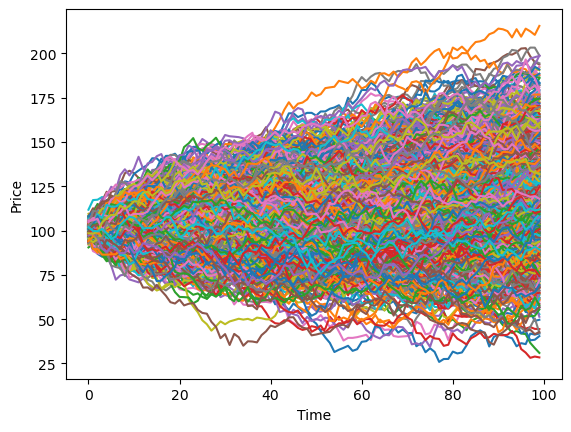

In [5]:
np.random.seed(42)
mu = 0.2
sigma = 0.3
S_0 = 100
time_horizon = 1
num_step = 100
num_path = 1000
dt = time_horizon/num_step
simu_size = (num_step,num_path)

start = np.ones(shape=(num_path,1))*S_0
norm_rand = np.random.normal(loc=0.0, scale=1.0, size=simu_size)
ds = (mu*dt + sigma * dt**(0.5) * norm_rand)*S_0
GBM = np.cumsum(ds,axis=0) + S_0

plt.plot(GBM)
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [6]:
print("The cdf of the simulation for the stock to have value at 80 is ",cdf_non_para(GBM[:,-1], 80))
print("The value at risk of the simulating stock at alpha = 0.05 is ", var_non_para(GBM[:,-1], 0.05))
print("The expected shortfall of the simulating stock at alpha = 0.05 is ", ES_non_para(GBM[:,-1], 0.05))

The cdf of the simulation for the stock to have value at 80 is  0.03324030956047464
The value at risk of the simulating stock at alpha = 0.05 is  82.42889705526485
The expected shortfall of the simulating stock at alpha = 0.05 is  63.95641126926968
